# Cross-Methods are a Leak/Variance Trade-Off

  * John Mount, [Win Vector LLC](http://www.win-vector.com/)
  * Nina Zumel, [Win Vector LLC](http://www.win-vector.com/)
  * March 10, 2020
  * [https://github.com/WinVector/pyvtreat/blob/master/Examples/CrossVal/LeakTradeOff/](https://github.com/WinVector/pyvtreat/blob/master/Examples/CrossVal/LeakTradeOff/)

## Introduction

Cross-methods such as [cross-validation](https://en.wikipedia.org/wiki/Cross-validation_%28statistics%29), and [cross-prediction](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html#sklearn.model_selection.cross_val_predict) are effective tools for many machine learning, statisitics, and data science related applications. They are useful for parameter selection, model selection, impact/target encoding of high cardinality variables, stacking models, and super learning. They are more statistically efficient than partitioning training data into calibration/training/holdout sets, but do not satisfy the full exchangeability conditions that full hold-out methods have. This introduces some additional statistical trade-offs when using cross-methods, beyond the obvious increases in computational cost.

Specifically, cross-methods can introduce an information leak into the modeling process. This information leak will be the subject of this post.

To show the information leak, we will use a simple artificial problem where there is no relation between the proposed explanatory variable(s) and the output variable. This example is in the spirit of our previous article, [Bad Bayes: an example of why you need hold-out testing](http://www.win-vector.com/blog/2014/02/bad-bayes-an-example-of-why-you-need-hold-out-testing/), as well as the paper by Claudia Perlich Grzegorz Swirszcz, "On Cross-Validation and Stacking: Building Seemingly Predictive Models On Random Data", SIGKDD Explorations, volume 12, number 2, 2010.

We will demonstrate that even in this situation, target-encoding (or conditionally re-encoding) categorical variables prior to the model-fitting step leaks information about the dependent variable. *This is true even when using cross-methods*. This leaked information may cause the downstream modeling step to treat noise variables as informative ones, leading to overfit.

Finally, we will conclude with a more realistic case: a combination of useless and useful explanatory variables.  For our last example we will use our recommended package [`vtreat`](https://github.com/WinVector/pyvtreat) ([available for `Python`](https://github.com/WinVector/pyvtreat) and [available for `R`](https://github.com/WinVector/vtreat)). The `vtreat` package manages impact coding, cross-validation, and reporting in a convenient unit.

## Preliminaries


We will work some regression examples using `Python`/`Pandas`.  In addition to calling out what to look for in each result, we will add "`assert`" statements to doublecheck the results as we present them.

First we import our packages and modules, and set our pseudo-random state to make the result more easily reproducible.

In [1]:
import re

# https://numpy.org
import numpy

# https://pandas.pydata.org
import pandas

# https://seaborn.pydata.org
import seaborn

# https://matplotlib.org
import matplotlib.pyplot

# https://scikit-learn.org/
import sklearn.metrics
import sklearn.linear_model
import sklearn.model_selection
# https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html
import category_encoders

# https://www.statsmodels.org/
import statsmodels.api

# https://github.com/WinVector/pyvtreat/blob/master/Examples/CrossVal/LeakTradeOff/break_cross_val.py
# https://github.com/WinVector/data_algebra
from break_cross_val import mk_data, TransformerAdapter, Container, solve_for_partition, collect_relations

# https://github.com/WinVector/pyvtreat
import vtreat

In [2]:
numpy.random.seed(2020)
prng = numpy.random.RandomState(numpy.random.randint(2**32))

### Initial Example Data: The Pure Noise Case

Now we create some example data. The data has 100 rows of 10 categorical variables, with 50 levels each, and one constant variable.

In [3]:
d_example, y_example = mk_data(
    nrow=100,
    n_noise_var=10,
    n_noise_level=50,
    n_signal_var=0)

In [4]:
d_example

,const_col,noise_0,noise_1,noise_2,noise_3,noise_4,noise_5,noise_6,noise_7,noise_8,noise_9
0,a,nl_14,nl_48,nl_0,nl_36,nl_11,nl_37,nl_14,nl_0,nl_28,nl_41
1,a,nl_4,nl_45,nl_45,nl_6,nl_25,nl_10,nl_18,nl_37,nl_19,nl_38
2,a,nl_36,nl_38,nl_9,nl_34,nl_29,nl_49,nl_18,nl_14,nl_0,nl_7
3,a,nl_25,nl_31,nl_18,nl_36,nl_41,nl_30,nl_5,nl_31,nl_21,nl_21
4,a,nl_14,nl_24,nl_5,nl_5,nl_1,nl_23,nl_27,nl_42,nl_34,nl_6
...,...,...,...,...,...,...,...,...,...,...,...
95,a,nl_17,nl_13,nl_33,nl_13,nl_49,nl_31,nl_35,nl_32,nl_17,nl_35
96,a,nl_49,nl_43,nl_14,nl_3,nl_32,nl_47,nl_27,nl_23,nl_30,nl_36
97,a,nl_33,nl_47,nl_42,nl_17,nl_37,nl_48,nl_24,nl_29,nl_44,nl_37
98,a,nl_49,nl_28,nl_32,nl_40,nl_32,nl_26,nl_33,nl_4,nl_27,nl_41


In [5]:
y_example

array([ 0.35640831, -1.02966661,  0.10937507, -1.22461964,  1.98078615,
       -0.08133883, -0.8407814 ,  0.17419664, -0.26695962,  1.81730992,
       -0.40031323, -0.01591122,  0.06183108, -2.63659715, -1.23370528,
       -1.5720175 , -0.30802748, -1.12459106,  0.80999499, -0.58387749,
        0.56838667,  0.90359773,  0.98001598,  0.94958149, -0.15583399,
        1.3929476 ,  0.4957971 , -0.18760574, -0.97232061, -0.1383119 ,
       -1.98764929,  0.42246929, -0.25438059,  0.64496689, -0.12015076,
       -0.48352493,  0.53825049,  1.23793055,  0.14021035,  1.38925737,
        0.18708701,  0.45131922,  1.80806884, -0.51693141,  0.87514908,
        0.36805093, -0.36548753, -1.56253055, -0.88706849,  0.57927198,
       -0.2806769 , -0.07133204,  0.74667248, -0.81331984,  0.66688814,
        1.03676875,  1.00533415,  0.83378592, -0.81403847, -2.26635425,
       -0.99387029, -0.48577153, -0.51869578,  0.17533136, -0.79042072,
       -0.88466057,  0.21123103,  1.68172973,  0.41984886, -2.41

In this data all "noise variables" are generated independently of the outcome or dependent variable `y_example`.  `const_col` is a variable that does not vary: it always has the value "`a`". We want to fit a linear regression model for `y_example` to the data. Of course, such a model should predict nothing, since there is no relationship between the inputs and the output.

For our examples, we will re-encode each categorical variable into a single numerical encoding (here called a *target encoding*) where each level of the categorical variable is encoded as the (possibly smoothed) conditional mean of the *y* variable in the training set. Target encoding (and the similar [*impact coding*](https://www.r-bloggers.com/modeling-trick-impact-coding-of-categorical-variables-with-many-levels/)) can be useful when modeling with very high cardinality categorical variables (that is, categorical variables with a very large number of levels), or when modeling with many moderate cardinality categorical variables. In either case, target encoding, when used properly, is good for managing the "variable blowup" caused by encoding a single categorical variable into multiple indicator variables.

For more discussion, see [this article](http://www.win-vector.com/blog/2012/07/modeling-trick-impact-coding-of-categorical-variables-with-many-levels/) and [this one](http://www.win-vector.com/blog/2019/11/when-cross-validation-is-more-powerful-than-regularization/). 

## The Case of No Cross-Method

For this first example we will use [`category_encoders.target_encoder.TargetEncoder`](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html) to re-encode our categorical variables prior to a linear regression.  This target encoder re-encodes categorical variables as smoothed conditional estimates.

On its own, the encoder is not cross-validated. This means high complexity explanatory variables hide their true number of degrees of freedom and leak information.  This causes the variables to over-fit on training data even when they are useless on test data, as we will demonstrate below.

In [6]:
te0 = category_encoders.target_encoder.TargetEncoder()
d_coded_0 = te0. \
    fit_transform(d_example, y_example)
d_coded_0

,const_col,noise_0,noise_1,noise_2,noise_3,noise_4,noise_5,noise_6,noise_7,noise_8,noise_9
0,0.089719,0.878442,-0.279115,-0.134412,-0.293227,0.296913,-1.324166,0.448744,-0.547689,0.089719,1.090799
1,0.089719,-0.864603,0.074604,0.372476,-0.707656,-0.025692,-0.310375,-0.312264,0.089719,-0.509022,0.035622
2,0.089719,0.089719,0.122710,0.147765,-0.474352,1.145241,0.089719,-0.312264,0.491677,0.554715,0.127783
3,0.089719,-0.179738,0.039331,-0.347868,-0.293227,-0.964601,-0.178340,0.034212,-0.236233,-0.637285,0.420169
4,0.089719,0.878442,0.536216,-0.276830,0.770188,1.212039,0.640521,0.250698,0.384876,1.255121,-0.119833
...,...,...,...,...,...,...,...,...,...,...,...
95,0.089719,0.073256,0.481162,-0.509693,-1.043418,0.129405,-0.038776,-0.180355,0.089719,0.092802,0.089719
96,0.089719,1.086894,0.038942,-0.099632,0.053167,0.847704,0.089719,0.250698,0.232613,-0.200089,-0.125004
97,0.089719,-0.113104,0.089719,0.089719,-0.128602,-1.213415,-0.569695,-0.185133,0.089719,0.089719,-0.264294
98,0.089719,1.086894,0.885041,1.494380,0.182377,0.847704,0.933494,1.099114,1.340374,0.737929,1.090799


In [7]:
overfit_model = statsmodels.api.OLS(y_example, d_coded_0)
overfit_result = overfit_model.fit()

r2 = sklearn.metrics.r2_score(
    y_true=y_example, 
    y_pred=overfit_result.predict(d_coded_0))
assert r2 > 0.7
r2

overfit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     43.52
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           5.29e-30
Time:                        18:01:32   Log-Likelihood:                -60.214
No. Observations:                 100   AIC:                             142.4
Df Residuals:                      89   BIC:                             171.1
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const_col     -2.1941      0.558     -3.930      0.000      -3.303      -1.085
noise_0        0.3103      0.116      2.665      0.009       0.079       0.542
noise_1        0.2227      0.114      1.954      0.054      -0.004       0.449
noise_2        0.6015      0.127      4.754      0.000       0.350       0.853
noise_3        0.4393      0.126      3.499      0.001       0.190       0.689
noise_4        0.4852      0.102      4.760      0.000       0.283       0.688
noise_5        0.0554      0.121      0.459      0.647      -0.184       0.295
noise_6        0.1714      0.115      1.490      0.140      -0.057       0.400
noise_7        0.2075      0.127      1.635      0.106      -0.045       0.460
noise_8        0.4540      0.109      4.151      0.000       0.237       0.671
noise_9        0.4056      0.107      3.792      0.000       0.193       0.618
==============================================================================
Omnibus:                        5.411   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.067   Jarque-Bera (JB):                5.454
Skew:                           0.346   Prob(JB):                       0.0654
Kurtosis:                       3.910   Cond. No.                         12.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Notice the summary estimates a good adjusted R-squared (around 0.8), and finds many of the noise coefficients to be significant.  This is because the re-encoding step over-fit the data before we even got to the ordinary least squares regression.  We can confirm this by showing the model doesn't work on identically generated fresh data.

In [8]:
d_test, y_test = mk_data(
    nrow=100,
    n_noise_var=10,
    n_noise_level=50,
    n_signal_var=0)

d_test_coded = te0.transform(d_test)

r2 = sklearn.metrics.r2_score(
    y_true=y_test, 
    y_pred=overfit_result.predict(d_test_coded))
assert r2 < 0.2

r2

-0.25111316272369755

This can be an insidious issue: over-estimating model performance, and also allowing complex noise variables to outcompete low-complexity but actually useful explanatory variables.

Our advice to avoid this issue is to either use separate data for encoding and modeling, or use a cross-method when re-encoding the categorical variables.  This is what we are *very* careful to do correctly in [R vtreat](https://github.com/WinVector/vtreat) and [Python vtreat](https://github.com/WinVector/pyvtreat).

## Leave-One-Out Cross-Methods Data Leak

Let's take a quick look at how problems can arise even when using cross-methods.

In our opinion, to minimize data leaks one should avoid using a deterministic cross method plan, which can often pass through undesirable incidental structure in the data.  As such, we advise against using a leave-one-out cross-plan in production.

Leave-one-out leaks information in many places, including even in a constant column (a column that does not vary). To see this, let's try to fit a model for `y_example` using only `const_col`. First, we target-code `const_col`. We don't *need* to cross-validate a constant, but it is a problem that it doesn't work.

In [9]:
cv_one_out = sklearn.model_selection.LeaveOneOut()

# TransformAdapter adapts the TargetEncoder object for cross-methods
te2 = TransformerAdapter(
    category_encoders.target_encoder.TargetEncoder())

# Build the cross-validated encoding of the training data
# For use in training the model
cross_frame_0 = sklearn.model_selection.cross_val_predict(
    te2, 
    d_example[['const_col']], # just look at the constant column
    y_example, 
    cv=cv_one_out)
cross_frame_0 = pandas.DataFrame(cross_frame_0)
cross_frame_0.columns = ['const_col']

# This is the "transformed" training data
cross_frame_0

,const_col
0,0.087026
1,0.101026
2,0.089521
3,0.102996
4,0.070618
...,...
95,0.095556
96,0.093046
97,0.108241
98,0.058837


Notice that the re-encoding of the constant column varies per row. This is because in cross-methods the prediction is a function of the input *plus* the fold-id; it is *not* a function of the input alone.  For leave-one-out encoding of a constant, the encoding is `code[i] = (m * mean(y) - y[i])/(m - 1)`: the grand mean with the `i`-th row held out.  But this is equal to `m * mean(y) / (m - 1) - y[i] / (m - 1)`.  This means during training it is trivial to read off the `y`-values from the re-encoded constant column. To see this, we fit a linear regression model for `y_example` as a function of `cross_frame_0`, the re-encoded training data.

In [10]:
# fit a linear regression model as a function of the 
# target encoded training data
overfit_model_2 = statsmodels.api.OLS(
    y_example, 
    statsmodels.api.add_constant(   # add the DC intercept term
        cross_frame_0.values, 
        has_constant='add'))
overfit_result_2 = overfit_model_2.fit()

# calculate R-squared
r2 = sklearn.metrics.r2_score(
    y_true=y_example, 
    y_pred=overfit_result_2.predict(
        statsmodels.api.add_constant(
            cross_frame_0.values,
            has_constant='add')))
assert r2 > 0.9

overfit_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.305e+31
Date:                Tue, 10 Mar 2020   Prob (F-statistic):               0.00
Time:                        18:01:34   Log-Likelihood:                 3204.2
No. Observations:                 100   AIC:                            -6404.
Df Residuals:                      98   BIC:                            -6399.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.9719   2.48e-15   3.62e+15      0.000       8.972       8.972
x1           -99.0000   2.74e-14  -3.61e+15      0.000     -99.000     -99.000
==============================================================================
Omnibus:                        0.122   Durbin-Watson:                   0.324
Prob(Omnibus):                  0.941   Jarque-Bera (JB):                0.266
Skew:                          -0.066   Prob(JB):                        0.876
Kurtosis:                       2.784   Cond. No.                         93.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

What we see here is that we have apparently fit a perfect linear regression model for `y_example` using only a (re-encoded) constant input!

A crucial point to notice is that the regression used large magnitude (and negative) coefficients.  This is because there is a data leak, but it is low magnitude.  So to exploit the data leak we have to scale it up quite a bit. This is typical: many results in the literature that show the efficacy of cross-methods do so by proving that with high probability that method is very near a correct result *in norm*: that is, the norm of the difference between the cross-validated result and the true result is small. Our encoding was close to the true result, in this sense, but still represented a data leak, one that linear regression was able to exploit.

Again, this chimeric "well-fit model" will be useless on new data. Let's try it.

To try to work with new data, we want the target encoder to be fit on all the original training data. Note that the [`vtreat`](https://github.com/WinVector/pyvtreat) package, which we will discuss later, does not require this extra step.

In [11]:
# refit the target encoder on original data for later use
te2.fit(d_example[['const_col']], y_example) 

TransformerAdapter(model=TargetEncoder(cols=['const_col'], drop_invariant=False,
                                       handle_missing='value',
                                       handle_unknown='value',
                                       min_samples_leaf=1, return_df=True,
                                       smoothing=1.0, verbose=0))

Now we can apply the encoder to  new data.

In [12]:
# now target encode the new test data
d_test_coded_2 = te2.transform(d_test[['const_col']])

overfit_test_pred_2 = overfit_result_2.predict(
    statsmodels.api.add_constant(
        d_test_coded_2.values, 
        has_constant='add'))

r2 = sklearn.metrics.r2_score(y_true=y_test, y_pred=overfit_test_pred_2)
assert r2 < 0.2

r2

-0.012108850282850137

The leak we demonstrated above is one of the reasons `vtreat` uses impact codes (conditional difference from the mean) instead of target codes (conditional means). With cross-validated impact coding, constant variables will *always* code to zero, effectively identifying them as uninformative.

## Cross Method Done Correctly 

Now lets look at shuffled (pseudo-random) `k`-way cross method version of the target encoding.

For this example we look at all the input columns, and we will use 3-fold cross method. For a 3-fold cross-plan the bias from any one column is small, but many columns together will leak information.  We will demonstrate this next.

In [13]:
# Build a shuffled cross-plan
# http://www.win-vector.com/blog/2020/03/python-data-science-tip-dont-use-default-cross-validation-settings/
cvstrat = sklearn.model_selection.KFold(
    shuffle=True, 
    n_splits=3,
    random_state=prng)

te = category_encoders.target_encoder.TargetEncoder()
cross_frame = sklearn.model_selection.cross_val_predict(
    TransformerAdapter(te), 
    d_example, 
    y_example, 
    cv=cvstrat)

# Build the transformed training data
cross_frame = pandas.DataFrame(cross_frame)
cross_frame.rename(
    columns={i: d_example.columns[i] for i in
             range(d_example.shape[1])}, inplace=True)

cross_frame

,const_col,noise_0,noise_1,noise_2,noise_3,noise_4,noise_5,noise_6,noise_7,noise_8,noise_9
0,0.055096,0.055096,-0.572658,0.034988,0.055096,0.037668,0.055096,0.055096,0.055096,0.055096,0.055096
1,0.053041,-0.762554,0.687571,0.053041,0.053041,0.053041,0.054035,0.053041,0.053041,-0.711652,0.053041
2,0.055096,0.055096,0.055096,0.055096,0.055096,0.055096,0.055096,0.055096,0.573658,0.055096,0.055096
3,0.160505,0.160505,0.160505,-0.055440,0.160505,-0.400298,0.160505,0.160505,0.183377,-0.246219,0.468289
4,0.160505,0.160505,0.040946,0.160505,0.160505,0.814798,0.231655,-0.258593,0.160505,0.160505,-0.843376
...,...,...,...,...,...,...,...,...,...,...,...
95,0.160505,0.160505,0.160505,0.160505,0.160505,0.369370,0.109383,0.160505,0.160505,-0.040279,0.160505
96,0.053041,0.053041,0.053041,0.215618,0.053041,1.096685,0.053041,0.669725,0.053041,-0.377680,-0.067086
97,0.160505,0.160505,0.160505,0.160505,0.192124,-0.843376,0.160505,0.160505,0.160505,0.160505,0.100504
98,0.055096,0.055096,0.055096,0.055096,-0.355399,0.098604,0.055096,0.055096,0.055096,0.055096,0.055096


Again the encoded columns vary as a function of both the cross-fold and the input, so even the constant column varies after the re-encoding.

However, due to the proper use of a randomized cross-method these columns will still appear to be useless noise.  Their correlation with the output was not substantially elevated during the encoding. Conversely useful columns, if there were any, would remain useful in the re-encoding.  Below, we show that the re-encoded noise variables remain uncorrelated with the explanatory variable when we fit a linear model.

In [14]:
proper_fit_model = statsmodels.api.OLS(
    y_example, 
    statsmodels.api.add_constant(
        cross_frame.values, 
        has_constant='add'))
proper_fit_result = proper_fit_model.fit()

r2 = sklearn.metrics.r2_score(
    y_true=y_example, 
    y_pred=proper_fit_result.predict(
        statsmodels.api.add_constant(
            cross_frame.values,
            has_constant='add')))
assert r2 < 0.2

proper_fit_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.029
Method:                 Least Squares   F-statistic:                     1.265
Date:                Tue, 10 Mar 2020   Prob (F-statistic):              0.258
Time:                        18:01:35   Log-Likelihood:                -141.53
No. Observations:                 100   AIC:                             307.1
Df Residuals:                      88   BIC:                             338.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1989      0.231      0.861      0.392      -0.260       0.658
x1            -0.4560      2.452     -0.186      0.853      -5.328       4.416
x2            -0.0941      0.389     -0.242      0.809      -0.867       0.679
x3            -0.1700      0.290     -0.587      0.559      -0.746       0.406
x4            -0.4451      0.445     -1.001      0.320      -1.329       0.439
x5            -0.6703      0.382     -1.753      0.083      -1.430       0.090
x6             0.4572      0.273      1.674      0.098      -0.085       1.000
x7            -0.3084      0.405     -0.761      0.449      -1.114       0.497
x8             0.0349      0.275      0.127      0.899      -0.512       0.581
x9            -0.5848      0.431     -1.357      0.178      -1.441       0.272
x10            0.4283      0.294      1.457      0.149      -0.156       1.012
x11            0.3355      0.255      1.316      0.192      -0.171       0.842
==============================================================================
Omnibus:                        0.851   Durbin-Watson:                   1.968
Prob(Omnibus):                  0.653   Jarque-Bera (JB):                0.395
Skew:                           0.045   Prob(JB):                        0.821
Kurtosis:                       3.294   Cond. No.                         23.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can confirm from the summary that:

  * The overall model does not claim to be predictive
  * The individual coefficients appear to have non-significant p-values

This re-encoding failed to mess up the linear regression: uninformative variables correctly appear uninformative.  This appears to be good as we could hope for in this situation.

## Showing The Leak is Still There

However, there is still a data leak!

Code designed to look for the leak can find it. First we can identify from the encoded variables where the cross-folds are: wherever two rows have the same value for a variable, but see different encodings.  We demonstrate recovering the cross-plan here, by building a data leak machine that can recover `y_example` from the re-encoded noise variables, which should not be possible for variables unrelated to the output.

Here, we solve for complement sets: in this case, the complements of the folds of the cross-plan. Specifically, if row `i` is in fold `a`, the complement set for row `i` is the union of folds `b` and `c` (assuming a 3-fold cross-plan).

In [15]:
partition_solution = solve_for_partition(d_example, cross_frame)

partition_solution

,idx,complement
0,0,"[1, 3, 4, 5, 7, 10, 12, 14, 15, 16, 17, 19, 20..."
1,1,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17..."
2,2,"[1, 3, 4, 5, 7, 10, 12, 14, 15, 16, 17, 19, 20..."
3,3,"[0, 1, 2, 6, 8, 9, 10, 11, 12, 13, 16, 18, 20,..."
4,4,"[0, 1, 2, 6, 8, 9, 10, 11, 12, 13, 16, 18, 20,..."
...,...,...
95,95,"[0, 1, 2, 6, 8, 9, 10, 11, 12, 13, 16, 18, 20,..."
96,96,"[0, 2, 3, 4, 5, 6, 7, 8, 9, 11, 13, 14, 15, 17..."
97,97,"[0, 1, 2, 6, 8, 9, 10, 11, 12, 13, 16, 18, 20,..."
98,98,"[1, 3, 4, 5, 7, 10, 12, 14, 15, 16, 17, 19, 20..."


We know that the target encoder computes a conditional smoothed average of the dependent variable. We can use this knowledge to collect relations of the form `cross_frame[i, j] = dot(wts[i, j], y_example) + b`. 

`cross_frame[i, j]` is known. `wts[i, j]` is gotten by reading the [source code for the target encoder](https://github.com/scikit-learn-contrib/categorical-encoding/blob/master/category_encoders/target_encoder.py). We will solve for `y_example` and `b`.
 
We are proving there is a data leak by recovering `y_example` from the original input variable frame `d_example`, and the re-coded data frame `cross_frame`. There are ways to demonstrate the data leak without using `d_example`, but using `d_example` is simpler ot show.

We start with a new function `target_encoder_weight_rule` that is our adaptation of the original target encoder source code.

In [16]:
def target_encoder_weight_rule(
    *, nrow, partition_indexes, value_indexes,
        min_samples_leaf=1, smoothing=1.0):
    if (partition_indexes is None) or (len(partition_indexes) < 1):
        return None
    res = numpy.zeros(nrow)
    prior_w = 1 / len(partition_indexes)
    if (value_indexes is None) or (len(value_indexes) <= 1):
        res[partition_indexes] = prior_w
        return res
    stats_count = len(value_indexes)
    stats_mean_w = 1 / stats_count
    smoove = 1 / (1 + numpy.exp(-(stats_count - min_samples_leaf) / smoothing))
    res[partition_indexes] = prior_w * (1 - smoove)
    res[value_indexes] = res[value_indexes] + stats_mean_w * smoove
    return res

Now use the function to capture the block of weights (`relns_x`) and the map from the original training data elements to their cross-frame encodings (`relns_y`).

In [17]:
relns_x, relns_y = collect_relations(
    d_original=d_example,
    d_coded=cross_frame,
    d_partition=partition_solution,
    est_fn=target_encoder_weight_rule)

relns_x

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000000,0.015152,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000000,0.000000,...,0.015152,0.000000,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.000000,0.000000
1,0.014925,0.000000,0.014925,0.014925,0.014925,0.014925,0.014925,0.014925,0.014925,0.014925,...,0.000000,0.014925,0.000000,0.000000,0.014925,0.014925,0.000000,0.014925,0.014925,0.014925
2,0.000000,0.015152,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000000,0.000000,...,0.015152,0.000000,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.000000,0.000000
3,0.014925,0.014925,0.014925,0.000000,0.000000,0.000000,0.014925,0.000000,0.014925,0.014925,...,0.014925,0.014925,0.014925,0.014925,0.000000,0.000000,0.014925,0.000000,0.014925,0.014925
4,0.014925,0.014925,0.014925,0.000000,0.000000,0.000000,0.014925,0.000000,0.014925,0.014925,...,0.014925,0.014925,0.014925,0.014925,0.000000,0.000000,0.014925,0.000000,0.014925,0.014925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,0.004014,0.004014,0.004014,0.000000,0.000000,0.000000,0.004014,0.000000,0.004014,0.004014,...,0.004014,0.004014,0.004014,0.004014,0.000000,0.000000,0.004014,0.000000,0.004014,0.004014
1096,0.000000,0.015152,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000000,0.000000,...,0.015152,0.000000,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.000000,0.000000
1097,0.000000,0.015152,0.000000,0.015152,0.015152,0.015152,0.000000,0.015152,0.000000,0.000000,...,0.015152,0.000000,0.015152,0.015152,0.015152,0.015152,0.015152,0.015152,0.000000,0.000000
1098,0.004014,0.000000,0.004014,0.004014,0.004014,0.004014,0.369543,0.004014,0.004014,0.004014,...,0.000000,0.369543,0.000000,0.000000,0.004014,0.004014,0.000000,0.004014,0.004014,0.004014


In [18]:
relns_y

,code,i,j,level
0,0.055096,0,0,a
1,0.053041,1,0,a
2,0.055096,2,0,a
3,0.160505,3,0,a
4,0.160505,4,0,a
...,...,...,...,...
1095,0.267566,15,10,nl_31
1096,0.055096,81,10,nl_46
1097,0.055096,91,10,nl_18
1098,-0.114564,43,10,nl_18


In the above, `relns_y$code[k]` is `cross_frame[relns_y$i[k], relns_y$j[k]]`.

We picked up around 1000 linear relations between the 100 `y_example` values (which we are treating as unknowns) and individual entries from the encoded data frame (which we are saving in `relns_y`).  Many of these are going to be redundant, but we have enough of them to solve for `y_example`:

Let's call the matrix `[1 relns_x]` "*A*" (denoting that we added an initial column of ones), and the column vector `[b y_example]`"*y*". Then we expect that in matrix terms, *A* *y* = `relns_y$code`. This means *y* is the solution to linear equations, or a linear regression in our known quantities.

In [19]:
recover_model = sklearn.linear_model.Ridge(
    alpha = 1.0e-3, 
    normalize=True)
recover_model.fit(relns_x, relns_y['code'])
y_ests = recover_model.coef_

y_ests

array([ 0.38286542, -1.00067254,  0.13751294, -1.19657209,  2.00542574,
       -0.05263463, -0.81119794,  0.20031859, -0.2395179 ,  1.8427718 ,
       -0.37208945,  0.01201268,  0.09141795, -2.6040474 , -1.20241303,
       -1.54167653, -0.27971238, -1.09557047,  0.83786987, -0.55641342,
        0.59636352,  0.92991006,  1.00825944,  0.97554531, -0.12696112,
        1.41833807,  0.52306021, -0.15926224, -0.94035348, -0.1096274 ,
       -1.95732204,  0.44977575, -0.22599382,  0.67050963, -0.09243166,
       -0.45687631,  0.5651105 ,  1.26497826,  0.16751519,  1.41478549,
        0.21518778,  0.47819745,  1.83465353, -0.48868329,  0.90191182,
        0.39574586, -0.33710389, -1.5322998 , -0.85735641,  0.60634676,
       -0.2537905 , -0.0442353 ,  0.77219068, -0.7843696 ,  0.69461054,
        1.06297566,  1.03153519,  0.86000347, -0.78408083, -2.23598836,
       -0.96249331, -0.45846078, -0.49024196,  0.20390794, -0.76087746,
       -0.85466415,  0.23548188,  1.70830328,  0.44751128, -2.38

And these recovered estimates are in fact the original values of `y_example`.

In [20]:
r2 = sklearn.metrics.r2_score(y_true=y_example, y_pred=y_ests)
assert r2 > 0.9

r2

0.9993249813376227

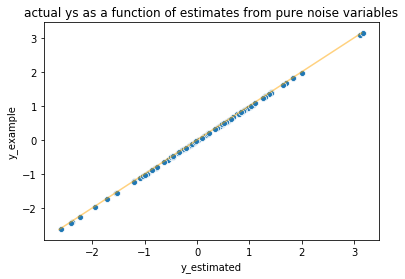

In [21]:
plt_frame = pandas.DataFrame({
    'y_example': y_example,
    'y_estimated': y_ests
})
sbn = seaborn.scatterplot(
    'y_estimated', 'y_example', data=plt_frame)
sbn.set_title(
    "actual ys as a function of estimates from pure noise variables")
true_range = [numpy.min(plt_frame['y_example']), 
              numpy.max(plt_frame['y_example'])]
_ = matplotlib.pyplot.plot(
        true_range, true_range,
        color='orange', alpha=0.5)

Again: what we have shown is that even when we target encode a set of pure noise variables using cross-methods, we can still recover `y_example` from the encoded variables. This means that the encoded noise variables can still potentially appear informative about `y_example` when used in a downstream model: cross-methods still leak information about the output variable.

Does this mean we shouldn't use cross-methods? Not necessarily. We'll discuss this more, below.

## Correct Cross Methods, The General Case

Before we get to the question of whether we should use cross-methods at all, let's look at the general case, where the data has both noise variables and signal carrying variables. For this example, we'll use 100 rows of ten noise variables and five signal-carrying variables, all of fifty levels each. We'll throw a constant column in there, too.

In [22]:
d_example_s, y_example_s = mk_data(
    nrow=100,
    n_noise_var=10,
    n_noise_level=50,
    n_signal_var=5)

In [23]:
d_example_s

,const_col,noise_0,noise_1,noise_2,noise_3,noise_4,noise_5,noise_6,noise_7,noise_8,noise_9,signal_0,signal_1,signal_2,signal_3,signal_4
0,a,nl_46,nl_41,nl_21,nl_49,nl_16,nl_17,nl_42,nl_16,nl_34,nl_9,a,b,a,b,a
1,a,nl_16,nl_27,nl_0,nl_5,nl_41,nl_5,nl_40,nl_23,nl_27,nl_42,a,a,a,b,b
2,a,nl_9,nl_34,nl_8,nl_35,nl_0,nl_24,nl_46,nl_35,nl_28,nl_25,a,a,b,a,a
3,a,nl_40,nl_31,nl_25,nl_35,nl_37,nl_19,nl_20,nl_46,nl_38,nl_9,b,a,a,a,b
4,a,nl_16,nl_35,nl_45,nl_28,nl_27,nl_44,nl_1,nl_12,nl_18,nl_31,b,b,a,a,a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,a,nl_24,nl_2,nl_4,nl_12,nl_44,nl_8,nl_0,nl_7,nl_48,nl_47,b,b,b,a,a
96,a,nl_9,nl_10,nl_17,nl_39,nl_2,nl_31,nl_4,nl_24,nl_12,nl_6,b,a,a,a,a
97,a,nl_9,nl_26,nl_3,nl_44,nl_7,nl_32,nl_42,nl_43,nl_30,nl_24,a,b,a,b,a
98,a,nl_12,nl_1,nl_16,nl_18,nl_26,nl_28,nl_20,nl_10,nl_39,nl_7,b,b,b,a,a


In [24]:
y_example_s

0     0.092855
1     0.702124
2     0.624716
3    -0.057869
4     2.984870
        ...   
95   -0.903519
96    2.625148
97    1.778676
98   -1.845954
99   -1.480355
Length: 100, dtype: float64

This time we will use `vtreat` to impact code all the variables with cross-methods, because we want to look at some extra information. Instructions for using `vtreat` for regression can be found [here](https://github.com/WinVector/pyvtreat/blob/master/Examples/Regression/Regression.md).

In [25]:
vtreat_coder = vtreat.NumericOutcomeTreatment(
    outcome_name = None,
    params = vtreat.vtreat_parameters({
        'coders': {'impact_code'},
        'filter_to_recommended': False
    }))
vtreat_cross_frame = vtreat_coder.fit_transform(d_example_s, y_example_s)

# the frame of cross-validated encoded variables
vtreat_cross_frame

,noise_0_impact_code,noise_1_impact_code,noise_2_impact_code,noise_3_impact_code,noise_4_impact_code,noise_5_impact_code,noise_6_impact_code,noise_7_impact_code,noise_8_impact_code,noise_9_impact_code,signal_0_impact_code,signal_1_impact_code,signal_2_impact_code,signal_3_impact_code,signal_4_impact_code
0,-2.775558e-17,-0.082937,0.000000,2.775558e-17,8.957836e-01,0.000000,0.000000e+00,-2.860668e+00,1.227627e-01,0.553686,0.734911,-1.195284,0.518659,-1.418944,0.609915
1,-2.126731e-01,-0.479059,-0.432493,0.000000e+00,-1.154976e-01,-0.469978,6.394952e-03,2.775558e-17,0.000000e+00,0.000000,0.724223,1.426430,0.502723,-1.277764,-0.478077
2,2.076853e+00,-1.252405,-0.050814,-5.230413e-01,0.000000e+00,0.061539,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.535319,1.377291,-0.862579,1.095629,0.542649
3,0.000000e+00,0.000000,0.000000,-5.230413e-01,0.000000e+00,0.000000,7.117627e-02,0.000000e+00,-1.431014e+00,-0.486062,-0.811250,1.377291,0.572315,1.095629,-0.511667
4,-4.668268e-01,0.000000,1.328000,0.000000e+00,-1.083165e+00,0.000000,-5.551115e-17,-5.551115e-17,1.240756e+00,0.000000,-0.954283,-1.351057,0.401000,1.220950,0.691481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.000000e+00,0.000000,0.000000,4.031278e-01,-3.880526e-01,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-0.811250,-1.233949,-0.862579,1.095629,0.542649
96,7.325165e-01,-0.085311,0.000000,2.775558e-17,2.775558e-17,1.637958,-1.032072e+00,2.775558e-17,-2.775558e-17,0.000000,-1.087247,1.340127,0.518659,1.178257,0.609915
97,7.325165e-01,0.332794,-1.521902,2.775558e-17,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,-2.775558e-17,-0.009648,0.734911,-1.195284,0.518659,-1.418944,0.609915
98,0.000000e+00,0.767260,0.000000,0.000000e+00,1.134287e+00,-0.238486,-2.246184e-01,0.000000e+00,0.000000e+00,0.000000,-1.202360,-1.102484,-0.690518,1.070849,0.565276


We have deliberately turned off `vtreat`'s feature pruning to allow the noise columns in, to demonstrate overfitting. `vtreat` itself has out-of-sample significance estimates which allow for reliable feature pruning.

In [26]:
vtreat_cross_frame.columns

Index(['noise_0_impact_code', 'noise_1_impact_code', 'noise_2_impact_code',
       'noise_3_impact_code', 'noise_4_impact_code', 'noise_5_impact_code',
       'noise_6_impact_code', 'noise_7_impact_code', 'noise_8_impact_code',
       'noise_9_impact_code', 'signal_0_impact_code', 'signal_1_impact_code',
       'signal_2_impact_code', 'signal_3_impact_code', 'signal_4_impact_code'],
      dtype='object')

Notice not all columns were coded; in particular, `vtreat` eliminates constant columns.  The columns considered are reported in `vtreat_coder.score_frame_`.

In [27]:
cols_to_show = ['variable', 'orig_variable', 'treatment', 'R2', 
                'significance', 'default_threshold', 'recommended']

vtreat_coder.score_frame_.loc[:, cols_to_show]

,variable,orig_variable,treatment,R2,significance,default_threshold,recommended
0,noise_0_impact_code,noise_0,impact_code,0.000004,9.840082e-01,0.066667,False
1,noise_1_impact_code,noise_1,impact_code,0.014053,2.401227e-01,0.066667,False
2,noise_2_impact_code,noise_2,impact_code,0.010295,3.151458e-01,0.066667,False
3,noise_3_impact_code,noise_3,impact_code,0.000676,7.973835e-01,0.066667,False
4,noise_4_impact_code,noise_4,impact_code,0.061040,1.320812e-02,0.066667,False
5,noise_5_impact_code,noise_5,impact_code,0.003886,5.377935e-01,0.066667,False
6,noise_6_impact_code,noise_6,impact_code,0.016734,1.995865e-01,0.066667,False
7,noise_7_impact_code,noise_7,impact_code,0.003024,5.868620e-01,0.066667,False
8,noise_8_impact_code,noise_8,impact_code,0.050362,2.479017e-02,0.066667,True
9,noise_9_impact_code,noise_9,impact_code,0.000023,9.619327e-01,0.066667,False


The above summary shows the R-squared (`R2`) of each variable when considered as a one-variable model for `y_example_s`, as well as the estimated significance (`significance`) of that fit. The R-squareds and significances are computed in a cross-validated manner, so they are good estimates of future out-of-sample performance.

The `recommended` column marks which variables have significances below the `default_threshold`, which itself is chosen to allow at most one uninformative column through (in expectation). In this case, we see that all the signal variables and only one noise variable are recommended.

From the score frame, we can examine the distribution of cross-validated significances grouped by whether the variable was a signal variable or not.

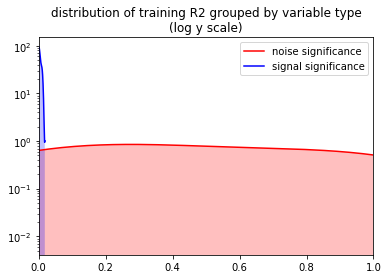

In [28]:
str_strip = re.compile('_.*$')
sig_frame = pandas.DataFrame({
    'significance': vtreat_coder.score_frame_['significance'],
    'variable_type': [str_strip.sub('', v) for v in 
                      vtreat_coder.score_frame_['variable']]
    })
splt = seaborn.kdeplot(
    sig_frame['significance'][sig_frame['variable_type'] == 'noise'], 
    color="r",
    shade=True,
    label='noise significance')
splt = seaborn.kdeplot(
    sig_frame['significance'][sig_frame['variable_type'] == 'signal'], 
    color="b",
    shade=True,
    label='signal significance')
splt.set(xlim=(0,1))
splt.set_yscale('log')
_ =splt.set_title('distribution of training R2 grouped by variable type\n(log y scale)')

It is as we would hope: the signaling variables have p-values concentrated near zero, and the noise variables have significances that are uniformly distributed in the interval `[0, 1]`.

Now we try fitting a linear model using the encoded frame:

In [29]:
good_model = statsmodels.api.OLS(
    y_example_s, 
    statsmodels.api.add_constant(
        vtreat_cross_frame.values, 
        has_constant='add'))
good_fit = good_model.fit()

train_r2 = sklearn.metrics.r2_score(
    y_true=y_example_s, 
    y_pred=good_fit.predict(
        statsmodels.api.add_constant(
            vtreat_cross_frame.values, 
            has_constant='add')))
assert train_r2 > 0.7

good_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     29.31
Date:                Tue, 10 Mar 2020   Prob (F-statistic):           4.52e-27
Time:                        18:01:40   Log-Likelihood:                -136.14
No. Observations:                 100   AIC:                             304.3
Df Residuals:                      84   BIC:                             346.0
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1934      0.120      1.608      0.112      -0.046       0.433
x1            -0.1831      0.167     -1.096      0.276      -0.515       0.149
x2             0.2513      0.208      1.210      0.230      -0.162       0.664
x3             0.0320      0.159      0.202      0.841      -0.283       0.347
x4             0.1212      0.210      0.577      0.565      -0.296       0.539
x5            -0.1123      0.186     -0.604      0.547      -0.482       0.257
x6            -0.3233      0.165     -1.961      0.053      -0.651       0.005
x7            -0.0417      0.162     -0.258      0.797      -0.363       0.280
x8             0.2390      0.169      1.417      0.160      -0.096       0.574
x9             0.1610      0.149      1.083      0.282      -0.135       0.457
x10           -0.1025      0.198     -0.517      0.606      -0.496       0.292
x11            1.1851      0.135      8.756      0.000       0.916       1.454
x12            0.8837      0.092      9.631      0.000       0.701       1.066
x13            1.4632      0.188      7.780      0.000       1.089       1.837
x14            0.8204      0.094      8.730      0.000       0.634       1.007
x15            1.8506      0.212      8.725      0.000       1.429       2.272
==============================================================================
Omnibus:                        2.383   Durbin-Watson:                   2.156
Prob(Omnibus):                  0.304   Jarque-Bera (JB):                1.621
Skew:                           0.057   Prob(JB):                        0.445
Kurtosis:                       2.387   Cond. No.                         3.34
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [30]:
sklearn.metrics.r2_score(
    y_true=y_example_s, 
    y_pred=good_fit.predict(
        statsmodels.api.add_constant(
            vtreat_cross_frame.values, 
            has_constant='add')))

0.8396086797764389

The linear model has a reasonable, but not outrageous, R-squared on the training data, and correctly estimates that the signal variables are more significant than the noise variables. 

More importantly, this model performs about the same on fresh identically distributed data. We can show this by generating test sets distributed identically to the training set, evaluating them with the model, and estimating R-squared.

In [31]:
def f():
    d_test_s, y_test_s = mk_data(
        nrow=100,
        n_noise_var=10,
        n_noise_level=50,
        n_signal_var=5)

    vtreat_test_frame = vtreat_coder.transform(d_test_s)

    return sklearn.metrics.r2_score(
                y_true=y_test_s, 
                y_pred=good_fit.predict(
                    statsmodels.api.add_constant(
                        vtreat_test_frame.values, 
                        has_constant='add')))

# the array of R-squared for the repeated tests
test_r2 = numpy.asarray([f() for i in range(100)])

In [32]:
assert numpy.mean(test_r2) >= train_r2 - 0.1

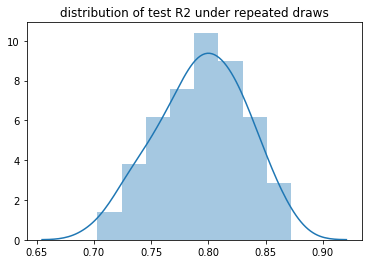

In [33]:
splot = seaborn.distplot(test_r2)
_ = splot.set_title('distribution of test R2 under repeated draws')

We expect that `category_encoders.target_encoder.TargetEncoder` would also handle the above example correctly.  And we could write code to break `vtreat`, just as we wrote code to break `category_encoders.target_encoder.TargetEncoder`. 

The point is `vtreat` is easy to use, and supplies a wide variety of safe and useful variable transforms for predictive modeling and machine learning. 

## So Should We Use Cross-Methods? Or Not?

In this article, we've shown that cross-methods *do* leak information about the training data, so it is not as "safe" in that sense as splitting training data into multiple partitions: one for setting parameters or calculating data transformations, one for training the model, and one for evaluating it. So if you have a large enough data set, partitioning it is probably preferable to cross-methods.
We've also seen that deterministic cross-method schemes like leave-one-out are particularly leaky.

On the other hand, we've also seen that the leak from randomized cross-methods is small enough that linear regression does not seem to see it: the linear models fit to randomized cross-validated encodings above correctly identified noise variables as uninformative most of the time. From experience, we (the authors) have seen that tree ensemble methods like random forest and gradient boosted trees also do not seem too sensitive to the leak ([here's an `xgboost` example](https://github.com/WinVector/pyvtreat/blob/master/Examples/KDD2009Example/KDD2009Example_no_filter.ipynb)).

So what we seem to be able to say is that cross-methods lower the information leak enough that the transformed training data appears safe to use with a reasonable downstream modeling algorithm. This is consistent with the results from superlearning and stacking, which use cross-methods to build "features" corresponding to the individual sub-learners, and then fit a model from these features to learn the overall ensemble model. Just as sometimes it is appropriate to introduce a bit of bias to for a large reduction in variance (bias/variance trade-off), it can be appropriate to pursue a favorable leak/variance trade-off.

It's worth noting that the recommended method to combine the sub-learners in stacking is non-negative linear regression, which is essentially a form of regularized regression. While [regularization is no substitute for cross-methods](http://www.win-vector.com/blog/2019/11/when-cross-validation-is-more-powerful-than-regularization/), it can certainly help reduce the possibility of overfit. As we saw above, linear regression *is* sensitive to the leave-one-out leak, because it can use large coefficients to multiply the leak's magnitude. Regularization would help prevent that, and non-negativity constraints completely eliminate the leak that we demonstrated, as that leak requires negative coefficients. So properly cross-validated encodings are typically "safe" at least when used with regularized regression.

What about tree ensemble methods? Random forest and gradient boosting are higher complexity models, so there is more risk that they might decode the leak. Our speculation is that the averaging inherent in random forest may serve as a "regularization" or smoothing step that helps mitigate this risk; and of course limiting the depth of the trees in a tree ensemble method is also a form of regularization.

### Even hold-out sets can be leaky!

However, re-using a cross-validated set multiple times within the model fitting process, for example with stepwise regression, or using cross-methods for multiple layers of nested models, probably increases the chance that the modeling algorithm will decode the leak. In fact, even hold-out sets leak information when used this way!

The last section of [this article](http://www.win-vector.com/blog/2015/10/a-simpler-explanation-of-differential-privacy/) shows an example of hold-out set leakage during stepwise regression. And [here](http://proceedings.mlr.press/v37/blum15.pdf) is an example of leaderboard hold-out set leakage during Kaggle competitions. The leakage in both these situations occurs because the hold-out set is used multiple times during the model fitting/model tuning/model selection process, and hence leaks information that leads to model overfit.

Model selection is *not* an unbiased procedure, and the bias, however small, can lead to information leakage. For any sort of hyper-parameter tuning or model search, the procedure is biased (though likely of small magnitude) no matter what hold-out procedure we use. Therefore, avoiding cross-validation leakage isn't the only problem.

## Practical Considerations

As we mentioned above, `vtreat` encodes high-cardinality categorical variables by their conditional difference from mean outcome (impact coding), rather than the conditional mean (target coding). Though the proof is out of scope of this article, impact coding has slightly lower variance, and a slightly lower magnitude leak for randomized cross-methods. However, the difference isn't very important in practice.

## Conclusion

We can summarize the takeaways from the experiments that we've shown here:

* If you have enough training data, partitioning it into sets for data transformations, model training, and evaluation may be preferable to cross-methods.
* If partitioning is not an option, cross methods may be good enough for reasonable applications.
* Avoid leave-one-out and other deterministic cross-method schemes.
* When using cross-validated encoded data, prefer regularized methods for the downstream model fitting when possible.
